In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyuvdata import UVData
from pyuvdata import uvutils
from hera_qm import ant_metrics
import hera_cal
from copy import deepcopy
from scipy.signal import medfilt2d

from matplotlib.colors import SymLogNorm
import sys
import os
from hera_qm import xrfi as xrfi
import numpy.ma as ma
import glob
import math

In [3]:

data_file_list = ['/data6/HERA/data/2458042/zen.2458042.12552.xx.HH.uv','/data6/HERA/data/2458042/zen.2458042.12552.yy.HH.uv','/data6/HERA/data/2458042/zen.2458042.12552.yx.HH.uv','/data6/HERA/data/2458042/zen.2458042.12552.xy.HH.uv']

uv = UVData()

uv.read_miriad(data_file_list)


Combined polarizations are not evenly spaced. This will make it impossible to write this data out to some file types.


In [4]:

aa = hera_cal.utils.get_aa_from_uv(uv)

info = hera_cal.omni.aa_to_info(aa)

reds = info.get_reds()


In [5]:

am = ant_metrics.Antenna_Metrics(data_file_list, reds, fileformat = 'miriad')


In [6]:

bases = []

lst = uv.get_antpairpols()

for i in range(uv.Nbls):
    
    pair = lst[4*i]
    
    bases.append((pair[0],pair[1]))
    
print bases


[(0, 0), (0, 1), (0, 2), (0, 11), (0, 12), (0, 13), (0, 14), (0, 23), (0, 24), (0, 25), (0, 26), (0, 27), (0, 36), (0, 37), (0, 38), (0, 39), (0, 40), (0, 41), (0, 50), (0, 51), (0, 52), (0, 53), (0, 54), (0, 55), (0, 65), (0, 66), (0, 67), (0, 68), (0, 69), (0, 70), (0, 71), (0, 82), (0, 83), (0, 84), (0, 85), (0, 86), (0, 87), (0, 88), (0, 98), (0, 120), (0, 121), (0, 122), (0, 123), (0, 124), (0, 141), (0, 142), (0, 143), (1, 1), (1, 2), (1, 11), (1, 12), (1, 13), (1, 14), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 65), (1, 66), (1, 67), (1, 68), (1, 69), (1, 70), (1, 71), (1, 82), (1, 83), (1, 84), (1, 85), (1, 86), (1, 87), (1, 88), (1, 98), (1, 120), (1, 121), (1, 122), (1, 123), (1, 124), (1, 141), (1, 142), (1, 143), (2, 2), (2, 11), (2, 12), (2, 13), (2, 14), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 50),

In [7]:

nonreds = []

for i in bases:
    
    flag = 0
    
    for j in reds:
        
        for k in j:
            
            if i == k:
                
                flag = 1
                
    if flag == 0:
        
        nonreds.append(i)
        
    
print nonreds


[(0, 0), (0, 98), (0, 143), (1, 1), (1, 98), (2, 2), (2, 98), (2, 120), (2, 141), (11, 11), (12, 12), (13, 13), (13, 98), (14, 14), (14, 98), (14, 120), (23, 23), (24, 24), (25, 25), (26, 26), (26, 98), (27, 27), (27, 98), (36, 36), (37, 37), (38, 38), (39, 39), (40, 40), (40, 98), (41, 41), (41, 98), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (55, 98), (65, 65), (65, 124), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (71, 98), (82, 82), (83, 83), (84, 84), (85, 85), (86, 86), (87, 87), (87, 98), (88, 88), (88, 98), (98, 98), (98, 124), (98, 143), (120, 120), (121, 121), (122, 122), (123, 123), (124, 124), (141, 141), (142, 142), (143, 143)]


In [8]:

v = deepcopy (uv)


In [9]:

def signal(amp,width,baseline):
    
    ant_1 = baseline[0]
    
    ant_2 = baseline[1]
    
    if (ant_1 == ant_2):
        
        return np.zeros((60*144/20,1024,4))
    
    ant_1_ind = np.where(uv.antenna_numbers==ant_1)
    
    ant_2_ind = np.where(uv.antenna_numbers==ant_2)
    
    dist = np.linalg.norm(uv.antenna_positions[ant_1_ind]-uv.antenna_positions[ant_2_ind])
    
    c = float(3e8)
    
    B = float(uv.freq_array[0][-1]-uv.freq_array[0][1])
    
    del_tau = 1. / B
    
    tau = (c * del_tau) / (dist * np.cos(15*np.pi / 180))
    
    temp = np.zeros((60*144/20,1024,4),dtype = complex)
    
    T = uv.Ntimes*10*144/20
    
    del_nu = 1. / T
    
    earth_rot = 1. / 86164.09053
    
    freq_naught = np.median(uv.freq_array[0])
    
    nu = earth_rot * dist * freq_naught / c
    
    temp = np.random.normal(amp,width,(60*144/20,1024,4)) * np.exp(nu_rang*(del_nu/nu)) * np.sinc(tau_rang*tau)
    
    result = np.fft.fftn(temp)
    
    return result
   

In [10]:

def noise(amp,width):
    
    real = np.random.normal(amp,width,(60*144/20,1024,4))
    
    imag = np.random.normal(amp,width,(60*144/20,1024,4))
    
    sig = np.array(real,dtype = complex)
    
    sig.imag = imag
    
    result = sig
    
    return result


In [11]:

nu_rang = np.zeros((60*144/20,1024,4))
    
tau_rang = np.zeros((60*144/20,1024,4))
    
for i in range(uv.Ntimes*144/20):
        
    nu_rang[i,:,:] = -i
        
for j in range(uv.Nfreqs/2 + 1):
        
    tau_rang[:,j,:] = j
    
    if (j != 0):
        
        tau_rang[:,-j,:] = j


In [12]:
v.Ntimes = 8640/20
v.Nblts = 9745920/20

In [ ]:

new_data_array = np.zeros((9745920/20, 1, 1024, 4),dtype = complex)

#sig_data_array = np.zeros((9745920, 1, 1024, 4),dtype = complex)

#noi_data_array = np.zeros((9745920, 1, 1024, 4),dtype = complex)

s_width = 1

s_amp = 0

i_width = 3

i_amp = 0

n_width = 0.25

n_amp = 0

xant = 23

x_width = 7.

x_amp = 0

for i in reds:
        
    sig = signal(s_amp,s_width,i[0])
    
    print 'working'
        
    for j in i:
        
        x_sig = 0
        
        i_sig = signal(i_amp,i_width,j)
        
        if ((j[0] == xant) or (j[1] == xant)):
            
            x_sig = signal(x_amp,x_width,j)
            
            norm_power = float(s_width**2)
            
            new_power = float(norm_power + i_width**2 + x_width**2)
            
            ratio = np.sqrt(norm_power/new_power)
            
            sigs = (sig + i_sig + x_sig) * ratio
            
        else:
            
            norm_power = float(s_width**2)
            
            new_power = float(norm_power + i_width**2)
            
            ratio = np.sqrt(norm_power/new_power)
            
            sigs = (sig + i_sig) * ratio
        
        indices = np.zeros(8640/20,dtype = int)
        
        start = int(v.antpair2ind(j[0],j[1])[0])
        
        for k in range(8640/20):
            
            indices[k] = int(start + k*1128)
        
        noi = noise(n_amp,n_width)
        
        visibility = sigs + noi
            
        new_data_array[indices,0,:,:] = visibility
        
        #sig_data_array[indices,0,:,:] = sig
        
        #noi_data_array[indices,0,:,:] = noi


In [30]:

for i in nonreds:
    
    print 'working'
    
    sig = signal(s_amp,s_width,i)
    
    i_sig = signal(i_amp,i_width,i)
        
    indices = np.zeros(8640/20,dtype = int)
        
    for k in range(8640/20):
            
        indices[k] = int(v.antpair2ind(i[0],i[1])[0] + k*1128)
            
    noi = noise(n_amp,n_width)
    
    x_sig = 0
    
    if ((i[0] == xant) or (i[1] == xant)):
            
        x_sig = signal(x_amp,x_width,i)
            
        norm_power = float(s_width**2)
            
        new_power = float(norm_power + i_width**2 + x_width**2)
            
        ratio = np.sqrt(norm_power/new_power)
        
        sigs = (sig + i_sig + x_sig) * ratio
        
    else:
        
        norm_power = float(s_width**2)
            
        new_power = float(norm_power + i_width**2)
            
        ratio = np.sqrt(norm_power/new_power)        
        
        sigs = (sig + i_sig) * ratio
            
    visibility = sigs + noi
            
    new_data_array[indices,0,:,:] = visibility
    
    #sig_data_array[indices,0,:,:] = sig
        
    #noi_data_array[indices,0,:,:] = noi
  

working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working
working


In [31]:

print new_data_array


[[[[  4.55229280e-02 +3.25586483e-01j  -1.47375232e-01 +2.27809795e-01j
     -1.64488154e-01 +2.60898465e-01j  -1.15437084e-01 +2.87905427e-01j]
   [ -2.43562844e-01 +3.17019305e-01j   8.50554163e-02 -2.46280670e-01j
      1.66559236e-01 -7.24132023e-02j   2.38180097e-02 +9.23417462e-03j]
   [ -4.33362109e-01 -5.16289320e-02j   1.08336967e-01 -6.70468710e-02j
      2.85774958e-01 +1.31262876e-01j  -4.83277516e-02 -2.58177670e-01j]
   ..., 
   [  1.65631123e-02 -1.39879901e-01j   1.00281506e-01 +5.08042902e-03j
      2.85747850e-02 +1.12073979e-02j   1.71486916e-02 -1.20542040e-02j]
   [ -3.20813893e-01 -2.19283359e-01j  -4.62462870e-02 +8.74687407e-02j
     -1.62316410e-01 +1.85272141e-01j  -2.03073304e-02 -2.57613083e-02j]
   [  9.32875556e-02 -2.16291833e-01j   2.26468482e-01 +3.72149442e-01j
     -1.66752076e-01 +5.15357109e-02j  -3.57914669e-01 +5.61917775e-01j]]]


 [[[ -1.09663427e+00 +8.22533028e-02j  -4.79650842e+00 +8.96535575e-01j
     -9.12670654e+00 +1.40043548e-02j  -4.312

In [32]:
v.data_array = new_data_array

<IPython.core.display.Javascript object>


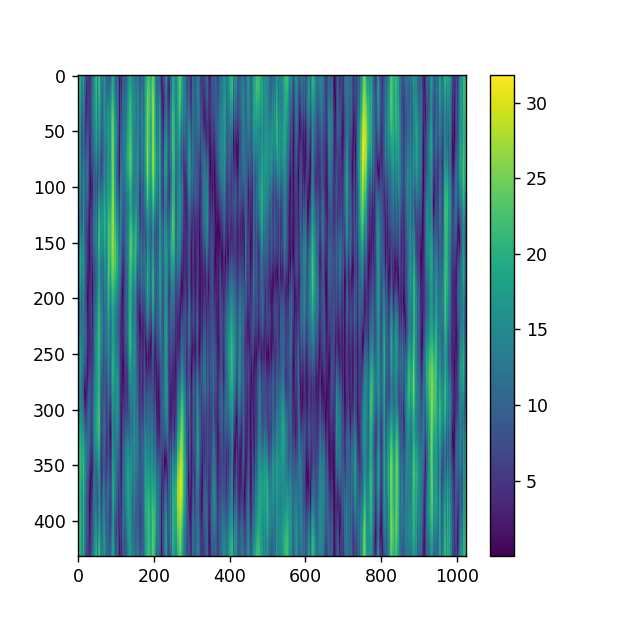

<IPython.core.display.Javascript object>


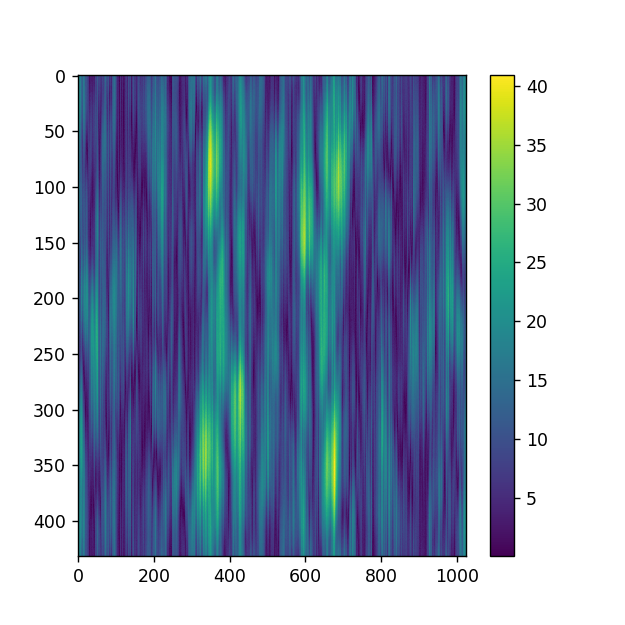

In [33]:
ant1,ant2 = 23,71

indices = np.zeros(8640/20,dtype = int)

start = v.antpair2ind(ant1,ant2)[0]

for i in range(8640/20):
    
    indices[i] = (start + i*1128)

data = new_data_array[indices,0,:,0]

plt.figure(figsize=(5,5))
#plt.imshow(np.angle(data), aspect='auto', norm=SymLogNorm(vmin=0,vmax=1,linthresh=.1))
plt.imshow(np.abs(data), aspect='auto')
plt.colorbar()
plt.show()


ant1,ant2 = 36,87

indices = np.zeros(8640/20,dtype = int)

start = v.antpair2ind(ant1,ant2)[0]

for i in range(8640/20):
    
    indices[i] = (start + i*1128)

data = new_data_array[indices,0,:,0]

plt.figure(figsize=(5,5))
#plt.imshow(np.angle(data), aspect='auto', norm=SymLogNorm(vmin=0,vmax=1,linthresh=.1))
plt.imshow(np.abs(data), aspect='auto')
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


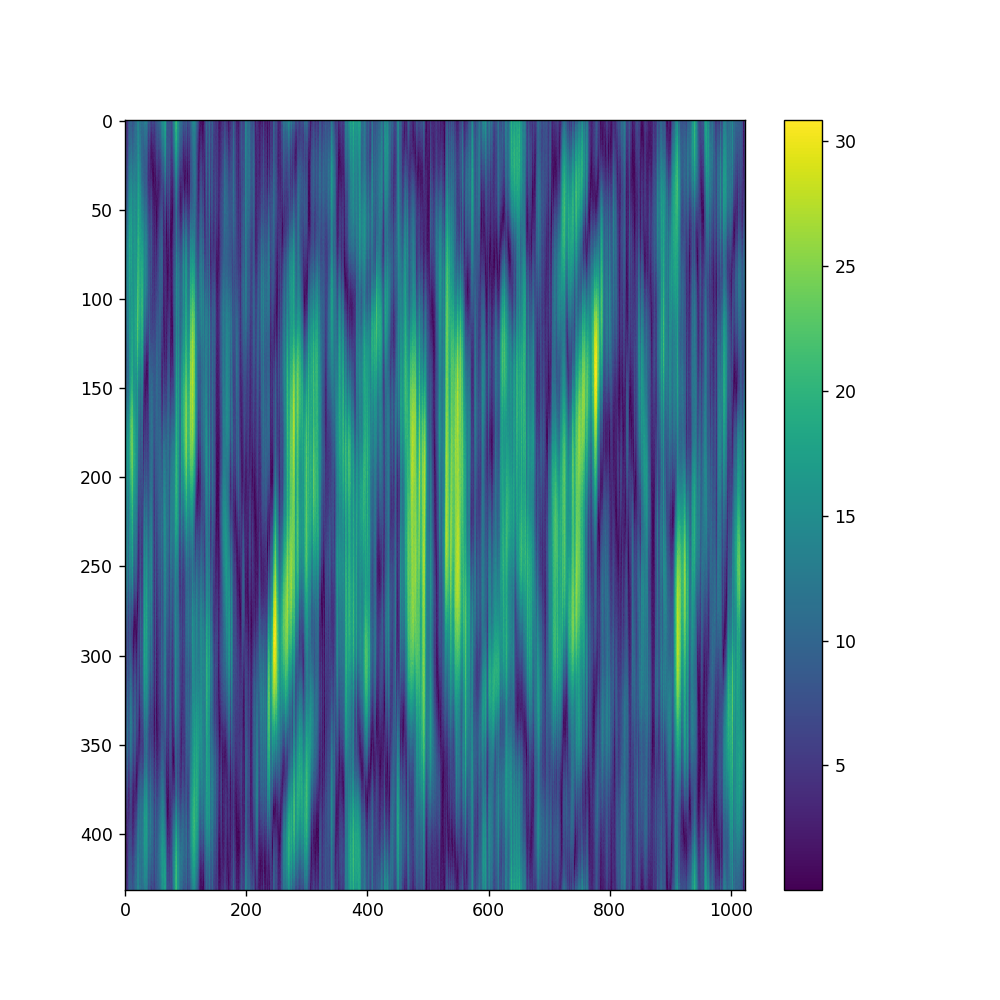

In [34]:
ant1,ant2 = 37,88

indices = np.zeros(8640/20,dtype = int)

start = v.antpair2ind(ant1,ant2)[0]

for i in range(8640/20):
    
    indices[i] = (start + i*1128)

data = new_data_array[indices,0,:,0]

plt.figure(figsize=(8,8))
#plt.imshow(np.angle(data), aspect='auto', norm=SymLogNorm(vmin=0,vmax=1,linthresh=.1))
plt.imshow(np.abs(data), aspect='auto')
plt.colorbar()
plt.show()


<IPython.core.display.Javascript object>


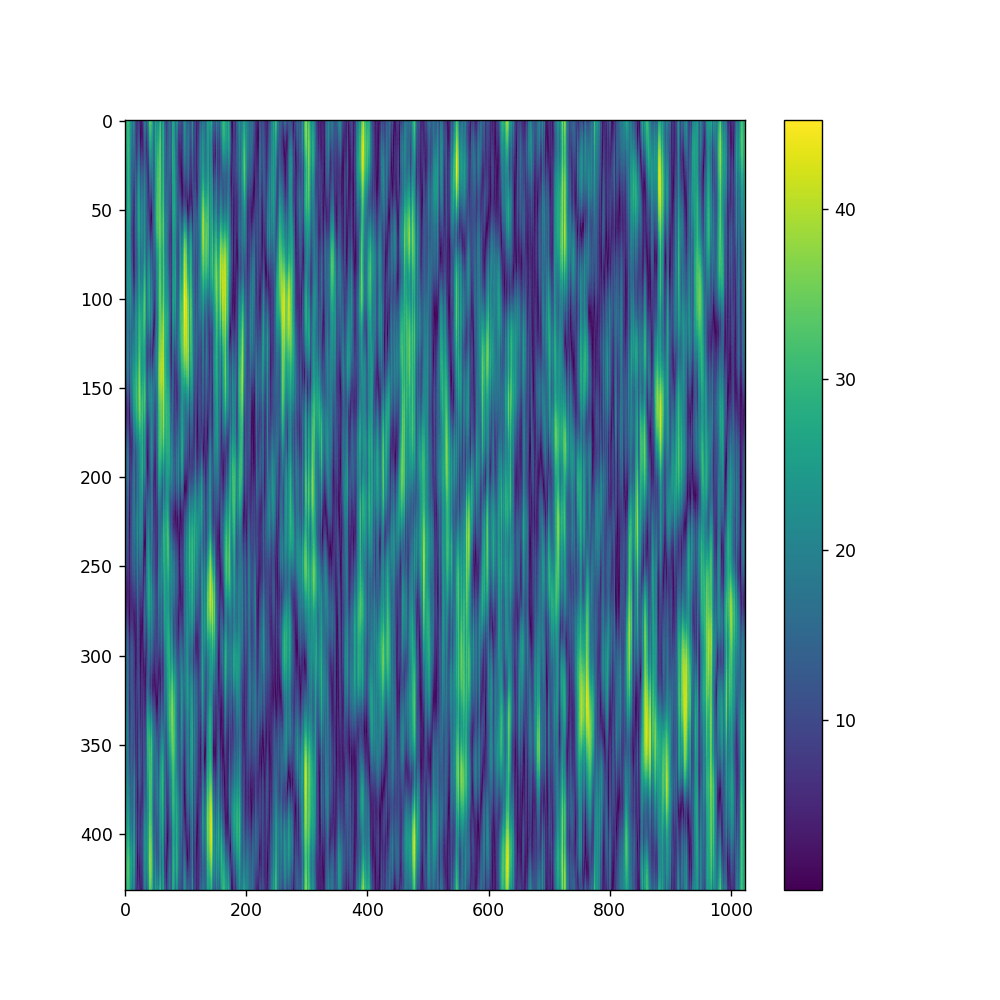

In [35]:
ant1,ant2 = 0,143

indices = np.zeros(8640/20,dtype = int)

start = v.antpair2ind(ant1,ant2)[0]

for i in range(8640/20):
    
    indices[i] = (start + i*1128)

data = new_data_array[indices,0,:,0]

plt.figure(figsize=(8,8))
#plt.imshow(np.angle(data), aspect='auto', norm=SymLogNorm(vmin=0,vmax=1,linthresh=.1))
plt.imshow(np.abs(data), aspect='auto')
plt.colorbar()
plt.show()


In [45]:
am.data.data_array = new_data_array

In [54]:
am.xants = []

In [47]:
rawRed = ant_metrics.red_corr_metrics(v,['xx','yy','xy','yx'],['x','y'],uv.antenna_numbers,reds,am.xants,rawMetric = True)

In [48]:
z_scores = ant_metrics.per_antenna_modified_z_scores(rawRed)

In [55]:

values = []

values_raw = []

for key in z_scores.keys():
    
    values.append(z_scores[key]) 
    
    values_raw.append(rawRed[key])


<IPython.core.display.Javascript object>


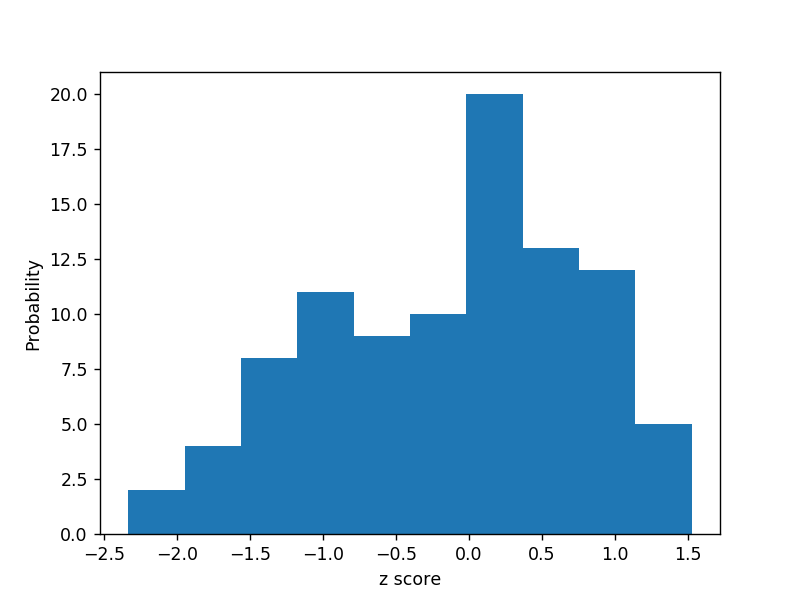

<IPython.core.display.Javascript object>


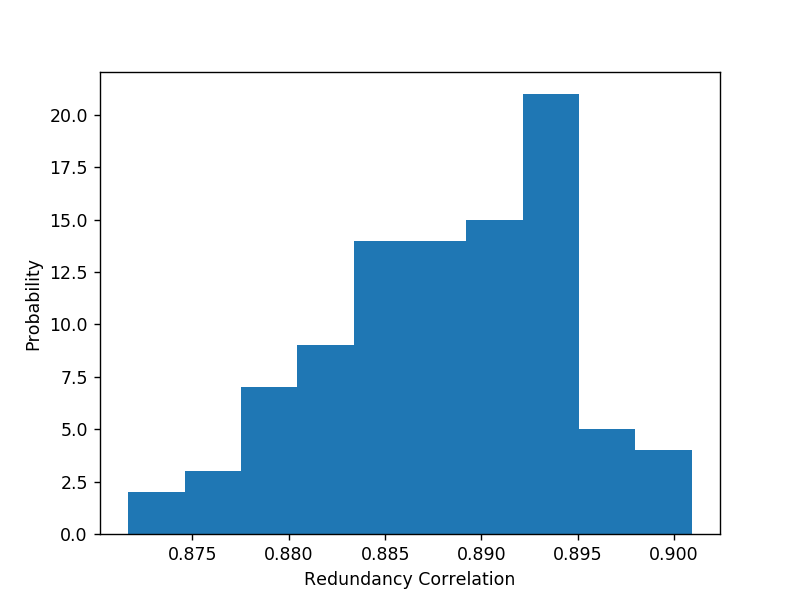

In [56]:
plt.figure()
plt.hist(values)
plt.xlabel('z score')
plt.ylabel('Probability')
plt.show()

plt.figure()
plt.hist(values_raw)
plt.xlabel('Redundancy Correlation')
plt.ylabel('Probability')
plt.show()

In [57]:

am.iterative_antenna_metrics_and_flagging(crossCut = 5,deadCut = 5)

print am.xants

TypeError: list indices must be integers, not tuple

In [53]:

def plot_metric(metrics, ants=None, antpols=None, title='', ylabel='Modified z-Score', xlabel=''):
    
    if ants is None:
        
        ants = list(set([key[0] for key in metrics.keys()]))
        
    if antpols is None:
        
        antpols = list(set([key[1] for key in metrics.keys()]))
        
    for antpol in antpols:
        
        for i,ant in enumerate(ants):
            
            metric = 0
            
            if metrics.has_key((ant,antpol)):
                
                metric = metrics[(ant,antpol)]
                
            plt.plot(i,metric,'.')
            
            plt.annotate(str(ant) + antpol, xy = (i,metrics[(ant,antpol)]))
            
        plt.gca().set_prop_cycle(None)
        
    plt.title(title)
    
    plt.xlabel(xlabel)
    
    plt.ylabel(ylabel)
    
    plt.show()
 

<IPython.core.display.Javascript object>


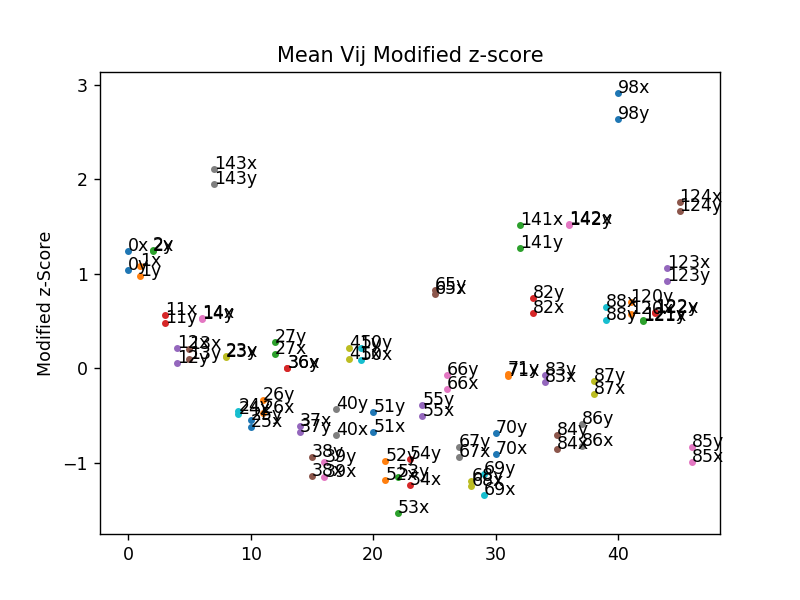

<IPython.core.display.Javascript object>


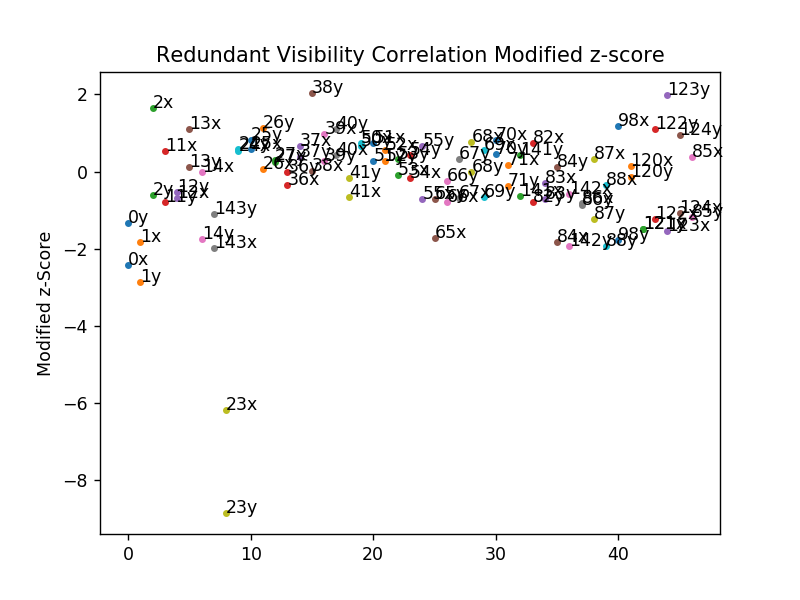

<IPython.core.display.Javascript object>


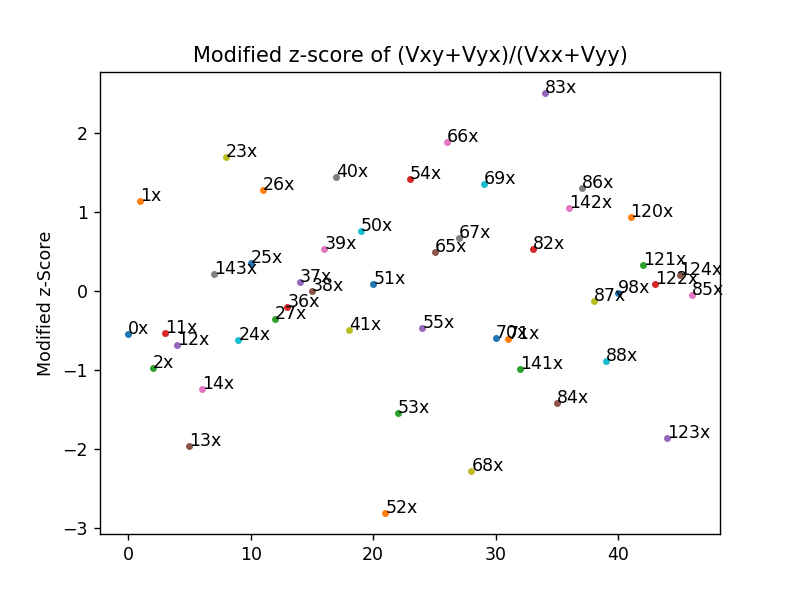

<IPython.core.display.Javascript object>


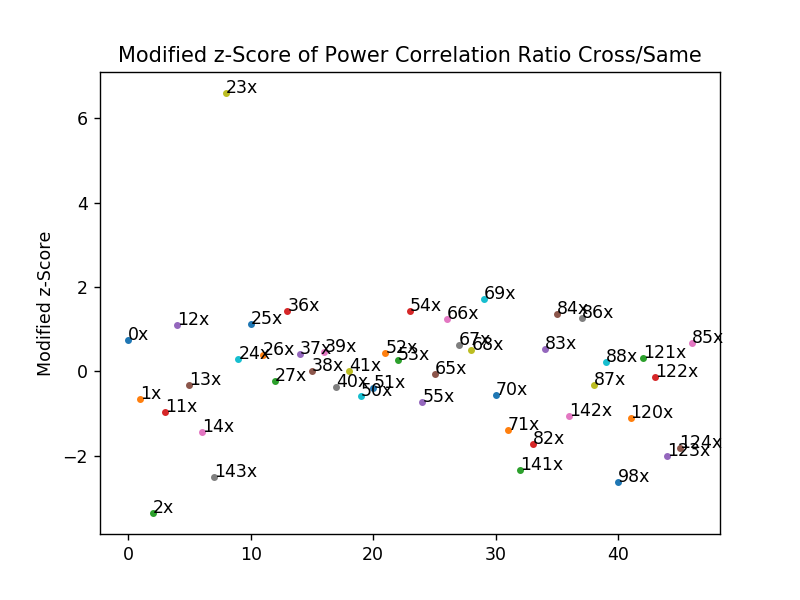

In [58]:

plt.figure()

plot_metric(am.finalModzScores['meanVij'],title='Mean Vij Modified z-score')

plt.figure()

plot_metric(am.finalModzScores['redCorr'],title = 'Redundant Visibility Correlation Modified z-score')

plt.figure()

plot_metric(am.finalModzScores['meanVijXPol'],antpols = ['x'], title = 'Modified z-score of (Vxy+Vyx)/(Vxx+Vyy)')

plt.figure()

plot_metric(am.finalModzScores['redCorrXPol'], antpols = ['x'], title = 'Modified z-Score of Power Correlation Ratio Cross/Same')


In [53]:
rawRed_new = ant_metrics.red_corr_metrics(v,['xx','yy','xy','yx'],['x','y'],uv.antenna_numbers,reds,am.xants,rawMetric = True)

In [54]:
z_scores_new = ant_metrics.per_antenna_modified_z_scores(rawRed_new)

In [55]:

values_new = []

values_raw_new = []

for key in z_scores.keys():
    
    values_new.append(z_scores_new[key]) 
    
    values_raw_new.append(rawRed_new[key])

<IPython.core.display.Javascript object>


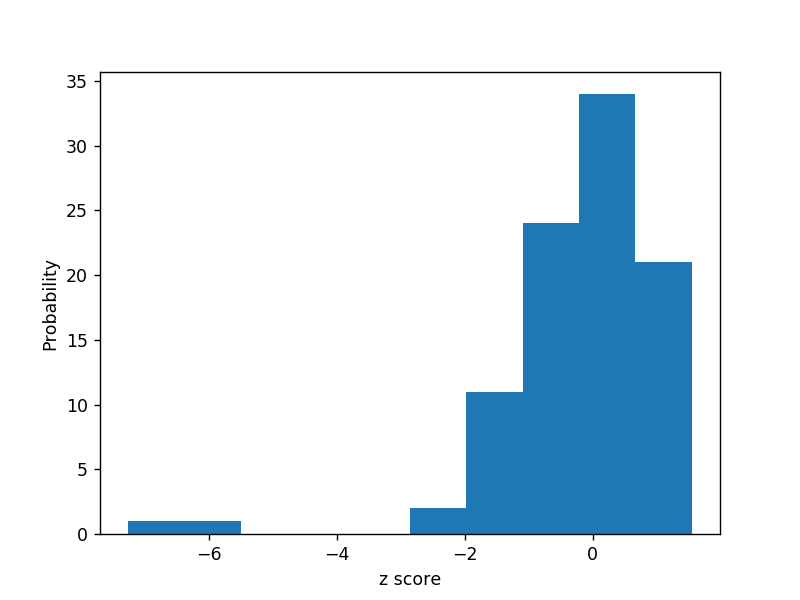

<IPython.core.display.Javascript object>


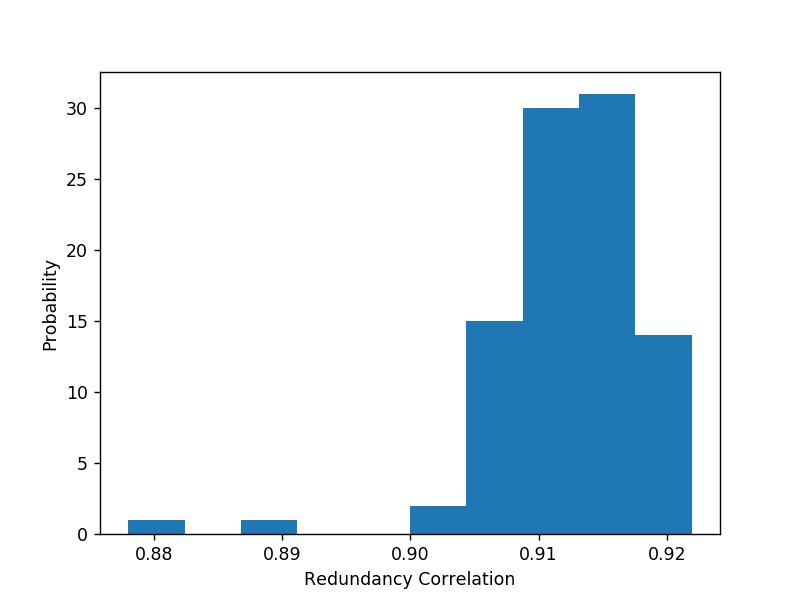

In [59]:
plt.figure()
plt.hist(values_new)
plt.xlabel('z score')
plt.ylabel('Probability')
#plt.xlim(-2,2)
plt.show()

plt.figure()
plt.hist(values_raw_new)
plt.xlabel('Redundancy Correlation')
plt.ylabel('Probability')
plt.show()

In [26]:
a = np.zeros((5,2,4))

a[0][0][1] = 3
a[4][1][3] = 2
a[1][0][0] = 4
a[3][0][2] = 1
a[2][1][3] = 1


print a

[[[ 0.  3.  0.  0.]
  [ 0.  0.  0.  0.]]

 [[ 4.  0.  0.  0.]
  [ 0.  0.  0.  0.]]

 [[ 0.  0.  0.  0.]
  [ 0.  0.  0.  1.]]

 [[ 0.  0.  1.  0.]
  [ 0.  0.  0.  0.]]

 [[ 0.  0.  0.  0.]
  [ 0.  0.  0.  2.]]]


In [29]:
test = np.zeros((5,2,4),dtype = complex)

In [35]:
test[:,:,0] = np.fft.fftn(a[:,:,0])
test[:,:,1] = np.fft.fftn(a[:,:,1])

print test

[[[ 4.00000000+0.j          3.00000000+0.j          0.00000000+0.j
    0.00000000+0.j        ]
  [ 4.00000000+0.j          3.00000000+0.j          0.00000000+0.j
    0.00000000+0.j        ]]

 [[ 1.23606798-3.80422607j  3.00000000+0.j          0.00000000+0.j
    0.00000000+0.j        ]
  [ 1.23606798-3.80422607j  3.00000000+0.j          0.00000000+0.j
    0.00000000+0.j        ]]

 [[-3.23606798-2.35114101j  3.00000000+0.j          0.00000000+0.j
    0.00000000+0.j        ]
  [-3.23606798-2.35114101j  3.00000000+0.j          0.00000000+0.j
    0.00000000+0.j        ]]

 [[-3.23606798+2.35114101j  3.00000000+0.j          0.00000000+0.j
    0.00000000+0.j        ]
  [-3.23606798+2.35114101j  3.00000000+0.j          0.00000000+0.j
    0.00000000+0.j        ]]

 [[ 1.23606798+3.80422607j  3.00000000+0.j          0.00000000+0.j
    0.00000000+0.j        ]
  [ 1.23606798+3.80422607j  3.00000000+0.j          0.00000000+0.j
    0.00000000+0.j        ]]]


In [34]:
b = np.array([[3,0],[0,0],[0,0],[0,0],[0,0]])

print np.fft.fftn(b)

[[ 3.+0.j  3.+0.j]
 [ 3.+0.j  3.+0.j]
 [ 3.+0.j  3.+0.j]
 [ 3.+0.j  3.+0.j]
 [ 3.+0.j  3.+0.j]]


In [1]:

new_data_array = np.zeros((9745920/20, 1, 1024, 4),dtype = complex)
#new_data_array = []


NameError: name 'np' is not defined